  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 📂Importing Dependencies📂 </div>



   We shall start by importing all the neccessary libraries. I will explain the exact use of each library later in this notebook.

In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset Preprocessing
  
  
In this notebook, I am using **Sentiment-140** from [Kaggle](https://www.kaggle.com/kazanova/sentiment140). It contains a labels data of 1.6 Million Tweets and I find it a good amount of data to train our model.

In [1]:
!pip install kaggle

You can see the columns are without any proper names. Lets rename them for our reference

In [2]:
# configuring the path of Kaggle.json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 98% 79.0M/80.9M [00:04<00:00, 24.1MB/s]
100% 80.9M/80.9M [00:04<00:00, 18.4MB/s]


In [5]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [9]:
df = pd.read_csv('/content/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)

In [12]:
df.columns = ['sentiment', 'id', 'date', 'query', 'user_id', 'text']
df.sample(6).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,sentiment,id,date,query,user_id,text
229938,0,1978620877,Sat May 30 23:55:49 PDT 2009,NO_QUERY,Rowan187,i have four blisters on my hand now ugh.
650196,0,2237496126,Fri Jun 19 05:53:56 PDT 2009,NO_QUERY,xoxostephtan,"@fuz182 you need to be invited by a member-- and not all members get the privilege to invite new members. i dont get to, unfortunately."
1195696,4,1984667191,Sun May 31 15:33:47 PDT 2009,NO_QUERY,sophieholly,@shaunadennett09 you awesome specimen of awesomness we're doing something after the 8th! and it should involve alcohol...xxxxxx
982194,4,1834182443,Mon May 18 01:56:55 PDT 2009,NO_QUERY,AussieGal999,"@justsal hey sal, good to hear from you and thanks for being along for the tweet ride"
111356,0,1825102788,Sun May 17 04:21:20 PDT 2009,NO_QUERY,LoboNY,"@RedCherryLips Kirks dad and son of Odin! I'm psyched for the movie. Still need to see Trek, though"
1529663,4,2177620745,Mon Jun 15 06:25:21 PDT 2009,NO_QUERY,arpitamukherjee,@CreativeWolf he he!! This club seems to be an ever expanding one i must say


We are going to train only on text to classify its sentiment. So we can ditch the rest of the useless columns.

In [13]:
df = df.drop(['id', 'date', 'query', 'user_id'], axis=1)

In [14]:
lab_to_sentiment = {0:"Negative", 4:"Positive"}
def label_decoder(label):
  return lab_to_sentiment[label]
df.sentiment = df.sentiment.apply(lambda x: label_decoder(x))
df.head().style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,sentiment,text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1,Negative,is upset that he can't update his Facebook by texting it... and might cry as a result School today also. Blah!
2,Negative,@Kenichan I dived many times for the ball. Managed to save 50% The rest go out of bounds
3,Negative,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there."


Here are decoding the labels. We map **0 -> Negative and 1 -> Positive** as directed by the datset desciption. Now that we decoded we shall now analyse the dataset by its distribution. Because it's important that we have almost small amount of examples for given classes.

Text(0.5, 1.0, 'Sentiment Data Distribution')

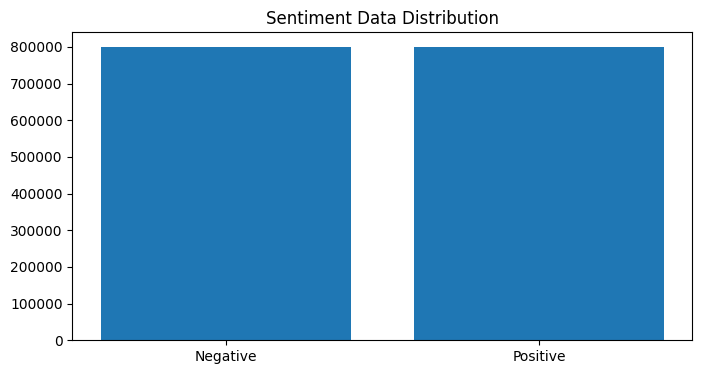

In [15]:
val_count = df.sentiment.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

It's a very good dataset without any skewness.

Now let us explore the data we having here...

In [16]:
import random
random_idx_list = [random.randint(1,len(df.text)) for i in range(10)] # creates random indexes to choose from dataframe
df.loc[random_idx_list,:].head(10).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'}) # Returns the rows with the index and display it

,sentiment,text
841571,Positive,"If you can take criticism and blame without resentment, YOU'RE PROBABLY THE FAMILY DOG see... http://jijr.com/hitZ cheers, Lou-ann"
1591055,Positive,@bulaw56: i heard you might be convening vmdc! details pleeeease. hehehe
1189138,Positive,Mm drinking out of my D-fusion cup!
1504443,Positive,i am pretty much done packing! i cannnnoottt wait to get out of this town! no work for a week+ TOO!
993620,Positive,Having a good morning last monday of high school !
615183,Negative,"Ugh, Sigma Brush set is still Out of Stock"
1155311,Positive,http://btweet.tumblr.com/ check it out guys
936016,Positive,@Burtens Once my 10k is done on Sunday I am gunning for you in the TSA Challenge! Just thought you should know
1550580,Positive,Went to the cutest vintage shop And got @NatLoveBug the most adorable something...
599918,Negative,Hello world. Head is banging oweeee Britney was fab! Having beans on toast then headin into work. Welcome home @KatieNK missed yoooouuu!!


Looks like we have a nasty data in text. Because in general we use lot of punctuations and other words without any contextual meaning. It have no value as feature to the model we are training. So we need to get rid of them.

# Text Preprocessing
Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model. We cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods.


### Stemming/ Lematization
For grammatical reasons, documents are going to use different forms of a word, such as *write, writing and writes.* Additionally, there are families of derivationally related words with similar meanings. The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.


### Hyperlinks and Mentions
Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.

- Twitter User Mentions - Eg. @arunrk7, @andrewng
- Hyperlinks - Eg. https://keras.io, https://tensorflow.org

### Stopwords
Stopwords are commonly used words in English which have no contextual meaning in an sentence. So therefore we remove them before classification.




In [17]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [18]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [19]:
df.text = df.text.apply(lambda x: preprocess(x))

**Aaww.. It is clean and tidy now. Now let's see some word cloud visualizations of it.**

### Positive Words

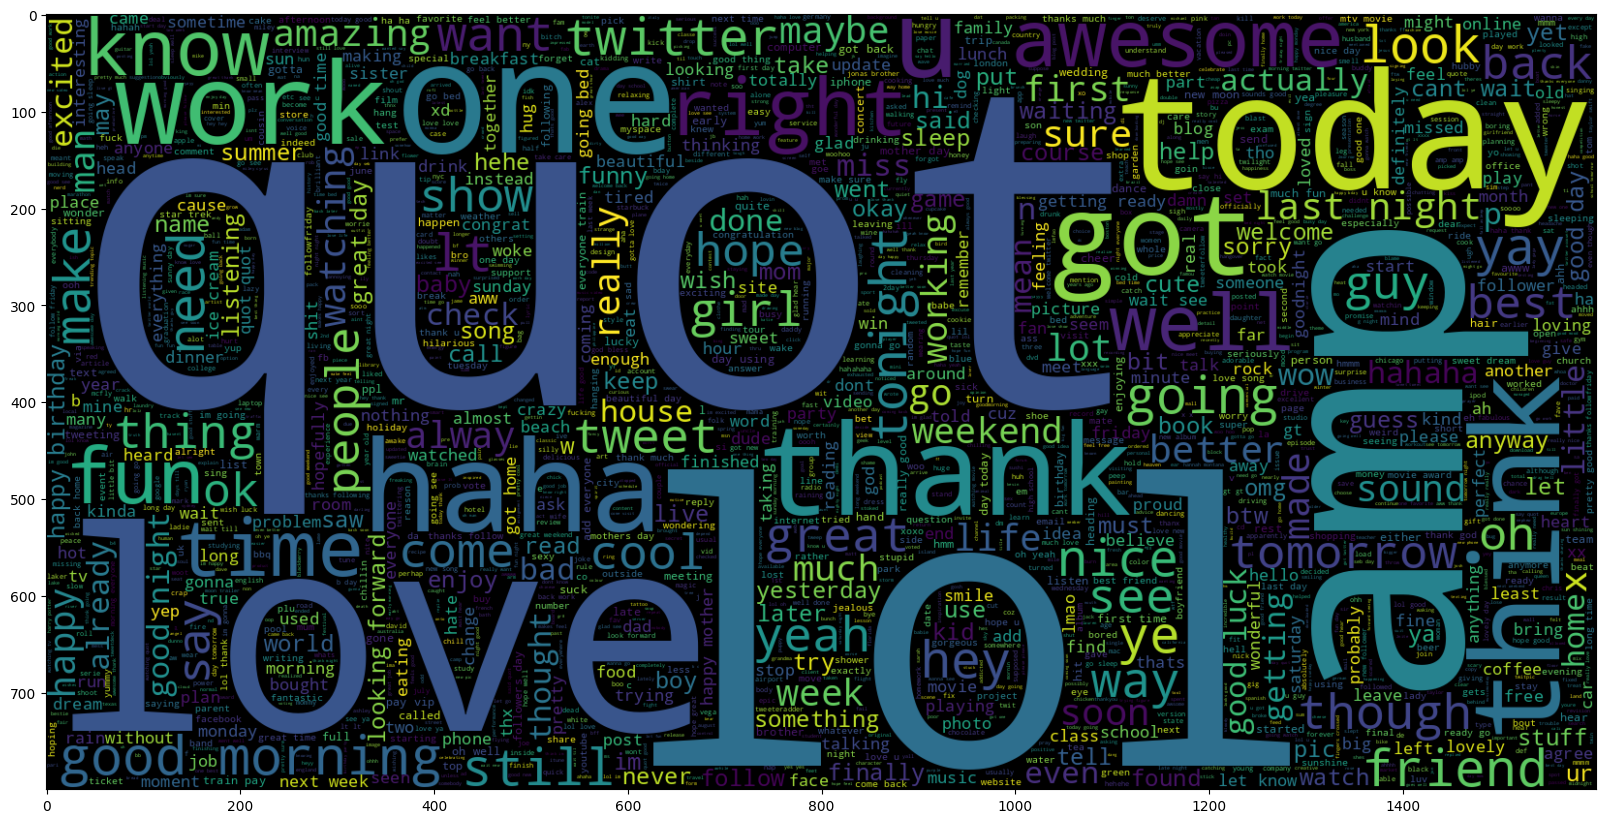

In [20]:
from wordcloud import WordCloud

plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Positive'].text))
plt.imshow(wc , interpolation = 'bilinear')

### Negative Words

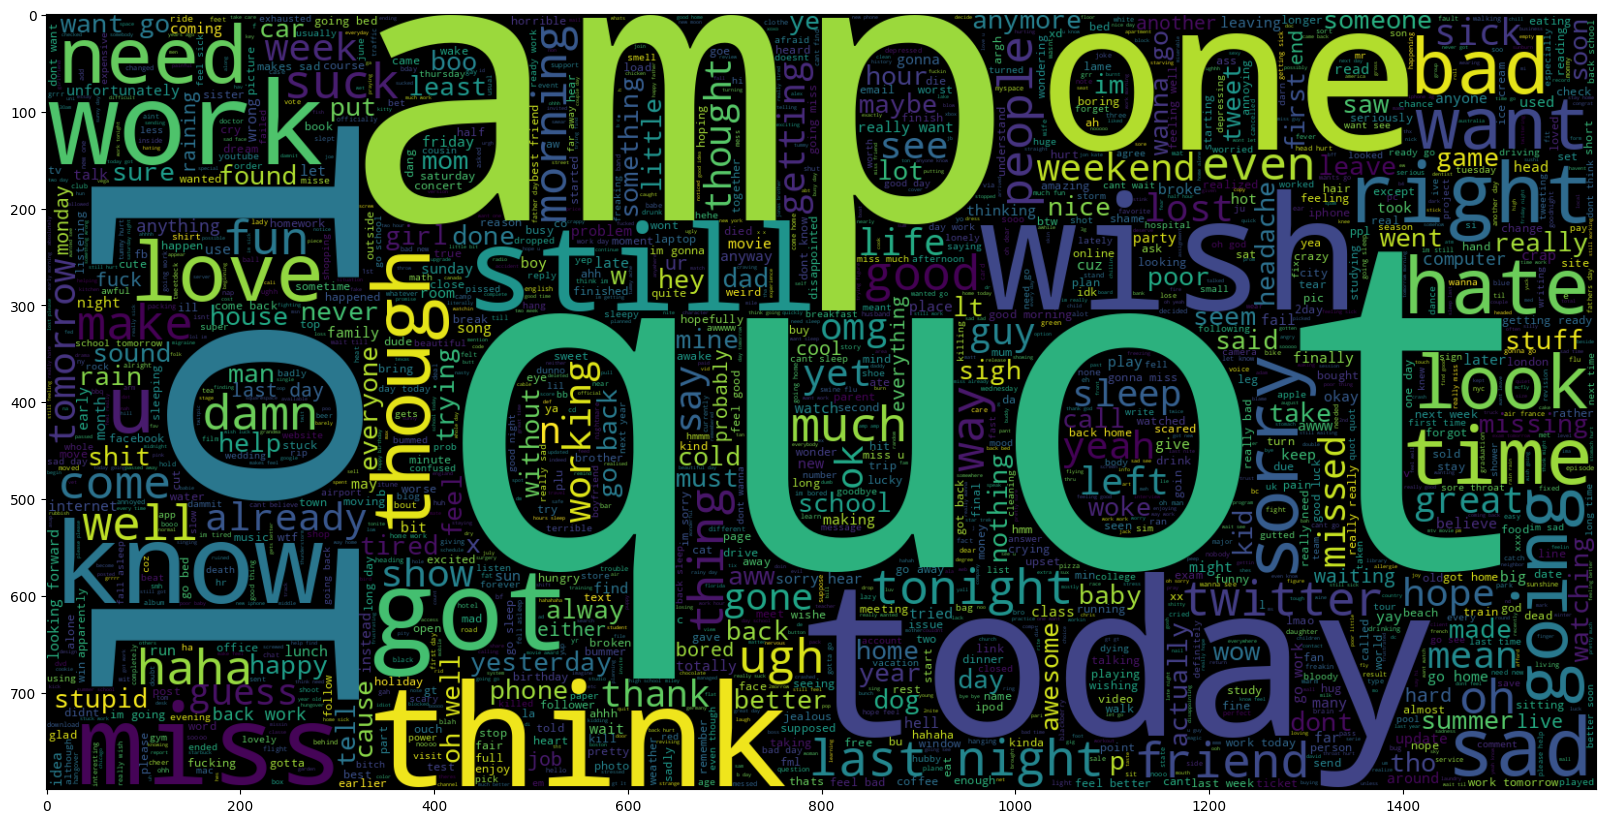

In [21]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 'Negative'].text))
plt.imshow(wc , interpolation = 'bilinear')

Train and Test Split

In [22]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [23]:
train_data, test_data = train_test_split(df, test_size=1-TRAIN_SIZE,
                                         random_state=7) # Splits Dataset into Training and Testing set
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 1280000
Test Data size 320000


train_test_split will shuffle the dataset and split it to gives training and testing dataset. It's important to shuffle our dataset before training.

In [24]:
train_data.sample(10).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'}) # Returns the rows with the index and display it

,sentiment,text
1479191,Positive,recycled second got home dad said solid happy myselff
689365,Negative,oh escape asshole neighbors
510185,Negative,sleep almost 3 30 grrrr
1353965,Positive,driven times originally derbyshire moved canada year never came back
237792,Negative,know haha rain sooooooooooo grrrrrrrr gt lol enter
108861,Negative,poor baby horrible cough
1150096,Positive,want say heart ontd
536301,Negative,love rob pattinson wouldnt throw saw know thats price u pay famous feel bad 4
1172366,Positive,stealing abbby09 facebook status cutting ties northwood today
1560057,Positive,contemplating dying hair get 200lbs like 3lbs go


 Tokenization

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 290575


Now we got a `tokenizer` object, which can be used to covert any word into a Key in dictionary (number).

Since we are going to build a sequence model. We should feed in a sequence of numbers to it. And also we should ensure there is no variance in input shapes of sequences. It all should be of same lenght. But texts in tweets have different count of words in it. To avoid this, we seek a little help from `pad_sequence` to do our job. It will make all the sequence in one constant length `MAX_SEQUENCE_LENGTH`.

In [26]:
from keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text),
                        maxlen = MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (1280000, 30)
Testing X Shape: (320000, 30)


In [27]:
labels = train_data.sentiment.unique().tolist()

  Label Encoding

We are building the model to predict class in enocoded form (0 or 1 as this is a binary classification). We should encode our training labels to encodings.

In [28]:
encoder = LabelEncoder()
encoder.fit(train_data.sentiment.to_list())

y_train = encoder.transform(train_data.sentiment.to_list())
y_test = encoder.transform(test_data.sentiment.to_list())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


Word Embedding

In [29]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2024-06-22 07:07:38--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-06-22 07:07:38--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-06-22 07:07:39--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [30]:
GLOVE_EMB = '/content/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 50
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [31]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [32]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [33]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🔥Model Training - LSTM🔥 </div>

In [34]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [35]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 embedding (Embedding)       (None, 30, 300)           87172500  
                                                                 
 spatial_dropout1d (Spatial  (None, 30, 300)           0         
 Dropout1D)                                                      
                                                                 
 conv1d (Conv1D)             (None, 26, 64)            96064     
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dense (Dense)               (None, 512)               66048 

Optimization Algorithm
This notebook uses Adam, optimization algorithm for Gradient Descent. You can learn more about Adam


In [37]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [38]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Training on GPU...


In [41]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=25,
                    validation_data=(x_test, y_test), callbacks=[ReduceLROnPlateau])

Epoch 1/25
1250/1250 [==============================] - 179s 143ms/step - loss: 0.4751 - accuracy: 0.7704 - val_loss: 0.4656 - val_accuracy: 0.7761 - lr: 0.0010
Epoch 2/25
1250/1250 [==============================] - 191s 153ms/step - loss: 0.4699 - accuracy: 0.7740 - val_loss: 0.4636 - val_accuracy: 0.7775 - lr: 0.0010
Epoch 3/25
1250/1250 [==============================] - 183s 146ms/step - loss: 0.4653 - accuracy: 0.7767 - val_loss: 0.4606 - val_accuracy: 0.7792 - lr: 0.0010
Epoch 4/25
1250/1250 [==============================] - 180s 144ms/step - loss: 0.4625 - accuracy: 0.7782 - val_loss: 0.4615 - val_accuracy: 0.7801 - lr: 0.0010
Epoch 5/25
1250/1250 [==============================] - 179s 144ms/step - loss: 0.4595 - accuracy: 0.7805 - val_loss: 0.4598 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 6/25
1250/1250 [==============================] - 192s 153ms/step - loss: 0.4573 - accuracy: 0.7814 - val_loss: 0.4595 - val_accuracy: 0.7814 - lr: 0.0010
Epoch 7/25
1250/1250 [============

 Model Evaluation

Now that we have trained the model, we can evaluate its performance. We will some evaluation metrics and techniques to test the model.

Let's start with the Learning Curve of loss and accuracy of the model on each epoch.

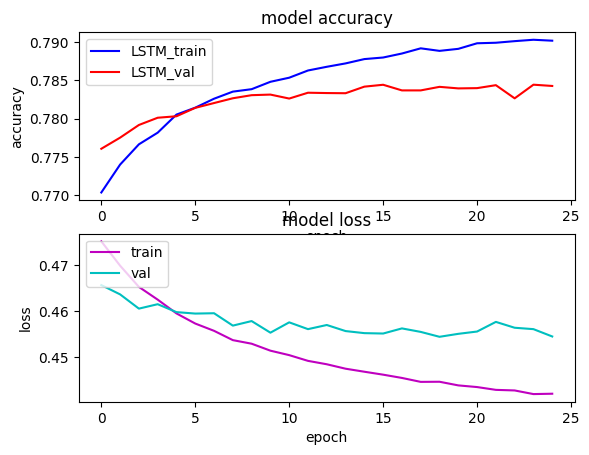

In [42]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

The model will output a prediction score between 0 and 1. We can classify two classes by defining a threshold value for it. In our case, I have set 0.5 as THRESHOLD value, if the score above it. Then it will be classified as **POSITIVE** sentiment.

In [43]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"


scores = model.predict(x_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

32/32 [==============================] - 3s 61ms/step


  <div style="color:#FF5733; background-color:#F7DC6F; padding: 20px; border-radius: 15px; font-size: 200%; font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; text-align:center; text-shadow: 2px 2px 4px rgba(0, 0, 0, 0.7);"> 🧾Confusion Matrix🧾 </div>

Confusion Matrix provide a nice overlook at the model's performance in classification task

In [44]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

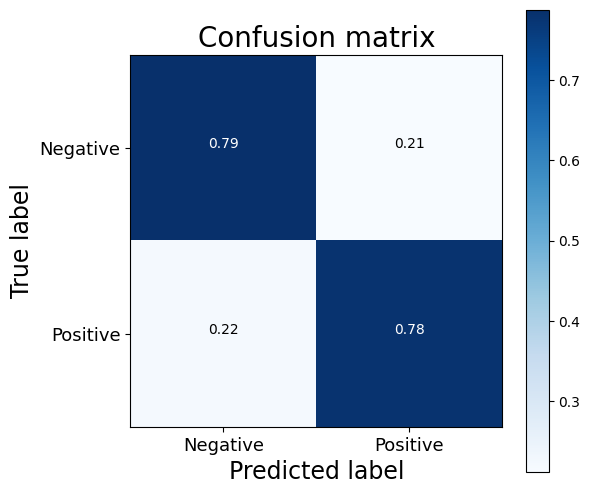

In [45]:
cnf_matrix = confusion_matrix(test_data.sentiment.to_list(), y_pred_1d)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=test_data.sentiment.unique(), title="Confusion matrix")
plt.show()

Classification Score

In [46]:
print(classification_report(list(test_data.sentiment), y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.78      0.79      0.79    160542
    Positive       0.79      0.78      0.78    159458

    accuracy                           0.78    320000
   macro avg       0.78      0.78      0.78    320000
weighted avg       0.78      0.78      0.78    320000



It's a pretty good model we trained here in terms of NLP. 79% accuracy is good enough considering the fact that we have over 1600000 tweets. Also, on further exploration of the dataset, some tweets might have other languages than English. So our Embedding and Tokenizing wont have effect on them. But on practical scenario, this model is good for handling most tasks for Sentiment Analysis.